## 1. About 

This notebook is used to generate graphcis for my bachelor thesis.

## 2. Code

### 2.1 Illustration SNN

In [1]:
import snntorch as snn
from snntorch import surrogate
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif"
})

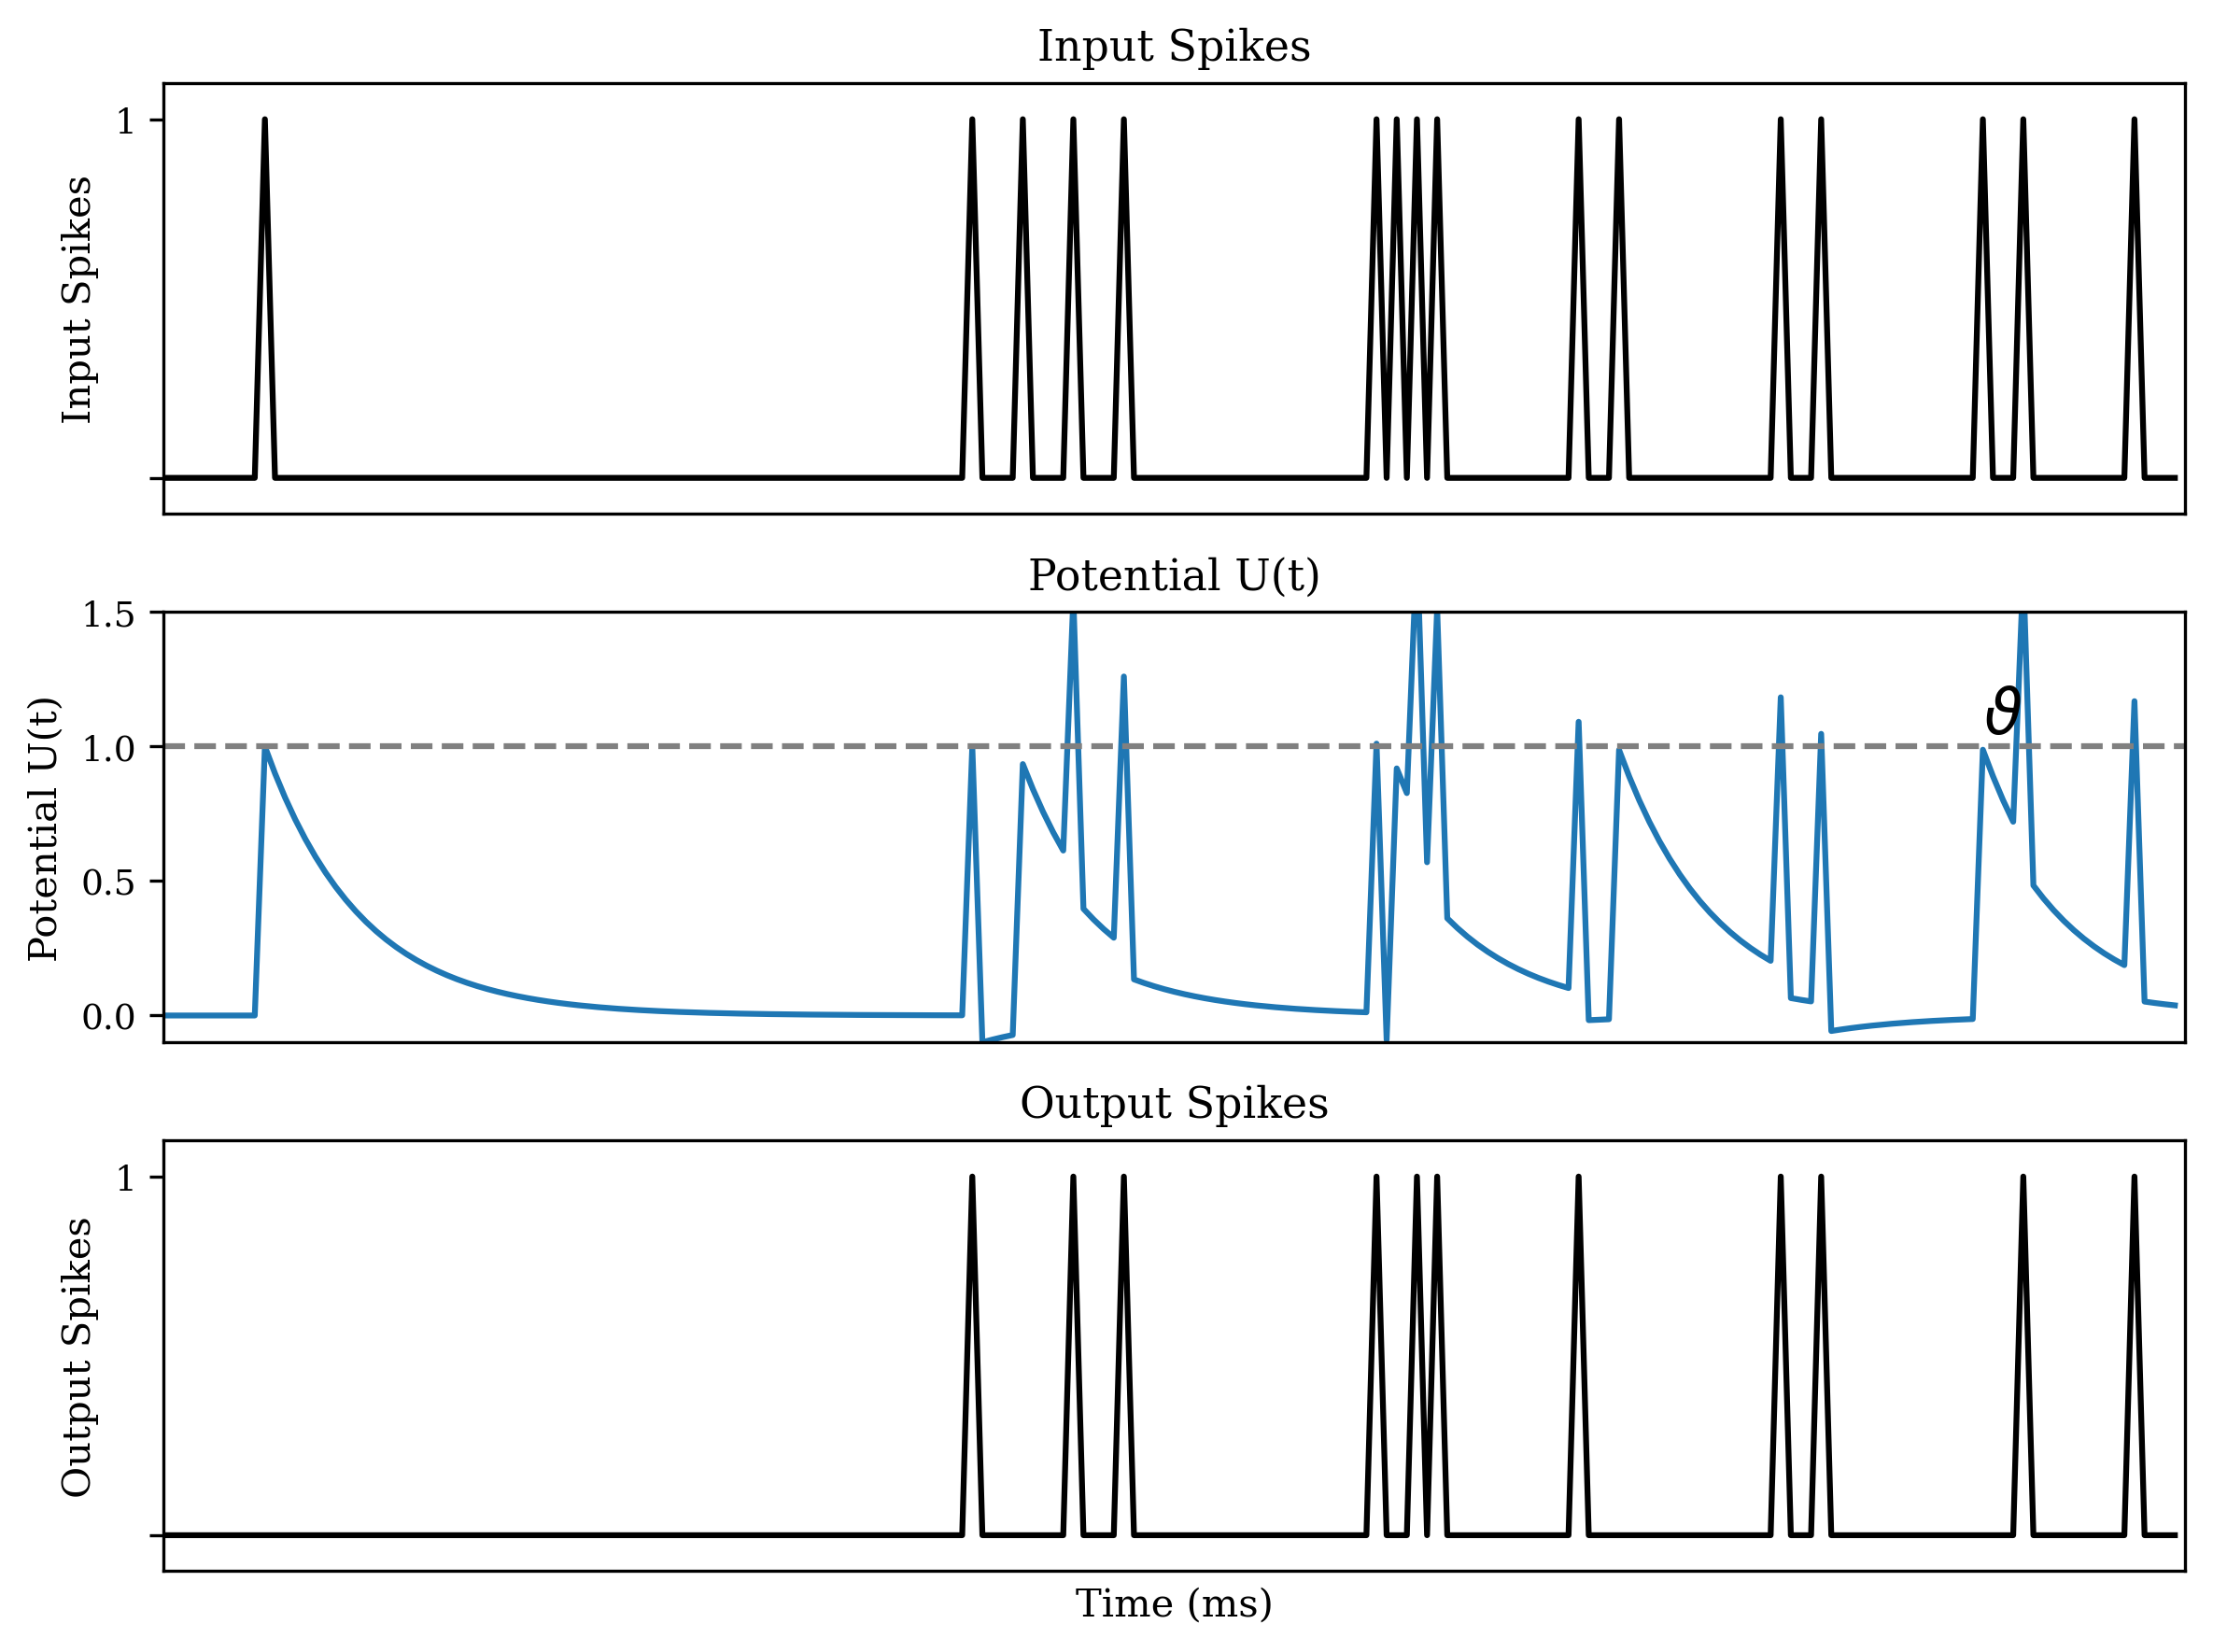

In [3]:
# Define simulation parameters
beta = 0.9  # membrane potential decay rate
threshold = 1  # neuron firing threshold
spike_grad = surrogate.atan()  # surrogate gradient for backpropagation
num_steps = 200  # simulation duration in time steps
input_size = 1 # Define input size explicitly

# Initialize LIF neuron
# Note: We remove init_hidden=True because we will manually manage the state
lif1 = snn.Leaky(beta=beta, threshold=threshold, spike_grad=spike_grad)

# Generate input spikes (similar to your image)
input_spikes = torch.zeros(num_steps, input_size)
input_spikes[10] = 1.0
input_spikes[80:100:5] = 1.0
input_spikes[120:128:2] = 1.0
input_spikes[140:148:4] = 1.0
input_spikes[160:168:4] = 1.0
input_spikes[180:188:4] = 1.0
input_spikes[195] = 1.0

# Store membrane potential and output spikes
mem_rec = []
spk_rec = []

# --- FIX: Initialize the internal states for the first step ---
mem = lif1.init_leaky() # Use the utility to initialize the membrane potential
spk = torch.zeros(input_size) # Initialize spike history (optional, but good practice)

# Simulate the neuron
for step in range(num_steps):
    # --- FIX: Pass the previous membrane potential (mem) as the second argument ---
    spk_out, mem_out = lif1(input_spikes[step].unsqueeze(0), mem)
    
    # Update the internal state for the next step
    mem = mem_out
    
    mem_rec.append(mem_out)
    spk_rec.append(spk_out)

# Convert lists to tensors
mem_rec = torch.stack(mem_rec).squeeze() # Squeeze to remove extra dimensions
spk_rec = torch.stack(spk_rec).squeeze()

# Plotting (Rest of your plotting code remains the same)
fig, ax = plt.subplots(3, figsize=(8, 6), sharex=True)

# Input Spikes
ax[0].plot(input_spikes.squeeze().numpy(), color='black')
ax[0].set_title("Input Spikes")
ax[0].set_ylabel("Input Spikes")
ax[0].set_yticks([0, 1])
ax[0].set_yticklabels(['', '1'])
ax[0].set_xticks([])
ax[0].set_xlim([0, num_steps])
ax[0].set_ylim([-0.1, 1.1])

# Membrane Potential
ax[1].plot(mem_rec.numpy())
ax[1].axhline(y=threshold, linestyle='--', color='gray', label='Threshold')
ax[1].set_title("Potential U(t)")
ax[1].set_ylabel("Potential U(t)")
# Adjusted y-limits for better visibility
ax[1].set_ylim([-0.1, 1.5]) 
ax[1].text(num_steps - 20, threshold + 0.05, r'$\vartheta$', fontsize=16)

# Output Spikes
ax[2].plot(spk_rec.numpy(), color='black')
ax[2].set_title("Output Spikes")
ax[2].set_xlabel("Time (ms)")
ax[2].set_ylabel("Output Spikes")
ax[2].set_yticks([0, 1])
ax[2].set_yticklabels(['', '1'])
ax[2].set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()
plt.show()

fig.savefig("lif_simulation.png", bbox_inches="tight")

### 2.2 Loss Graphics

In [4]:
import wandb
import pandas as pd
import seaborn

In [5]:
wandb.login()

wandb: Currently logged in as: lupos to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
api = wandb.Api()

# Replace with your W&B entity/project
runs = api.runs("lupos/Spike-Synth-Surrogate")

In [7]:
# Collect metrics from each run
data = []
for run in runs:
    summary = run.summary._json_dict
    config = {k: v for k, v in run.config.items() if not k.startswith('_')}
    name = run.name
    history = run.history(samples=10000)  # get all logged points
    history["run_name"] = name
    history["config"] = [config] * len(history)
    data.append(history)

df = pd.concat(data)

In [8]:
metric_cols = [
    c for c in df.columns
    if not c.startswith(("gradients", "config", "_")) and "run_name" not in c
]
print(metric_cols)

['lr', 'train_loss', 'trainer/global_step', 'epoch', 'val_loss', 'spikes/train_avg_layer_1', 'grad_mean/lif_layers.2', 'grad_mean/lif_layers.3', 'spikes/train_avg_layer_3', 'grad_mean/lif_layers.0', 'grad_mean/output_layer', 'grad_mean/lif_layers.1', 'spikes/train_avg_layer_0', 'spikes/train_avg_layer_2', 'grad_mean/lif_layers.4', 'spikes/train_avg_layer_4', 'spikes/train_avg_layer_5', 'grad_mean/lif_layers.5', 'spikes/train_avg_layer_7', 'spikes/train_avg_layer_6', 'grad_mean/lif_layers.7', 'grad_mean/lif_layers.6', 'spikes/train_avg_layer_9', 'grad_mean/lif_layers.8', 'grad_mean/lif_layers.9', 'spikes/train_avg_layer_8', 'grad_mean/layer_bntt', 'grad_mean/layer_norms', 'grad_mean/layer_skip_projs']


In [9]:
# Paper-friendly styling
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif"
})

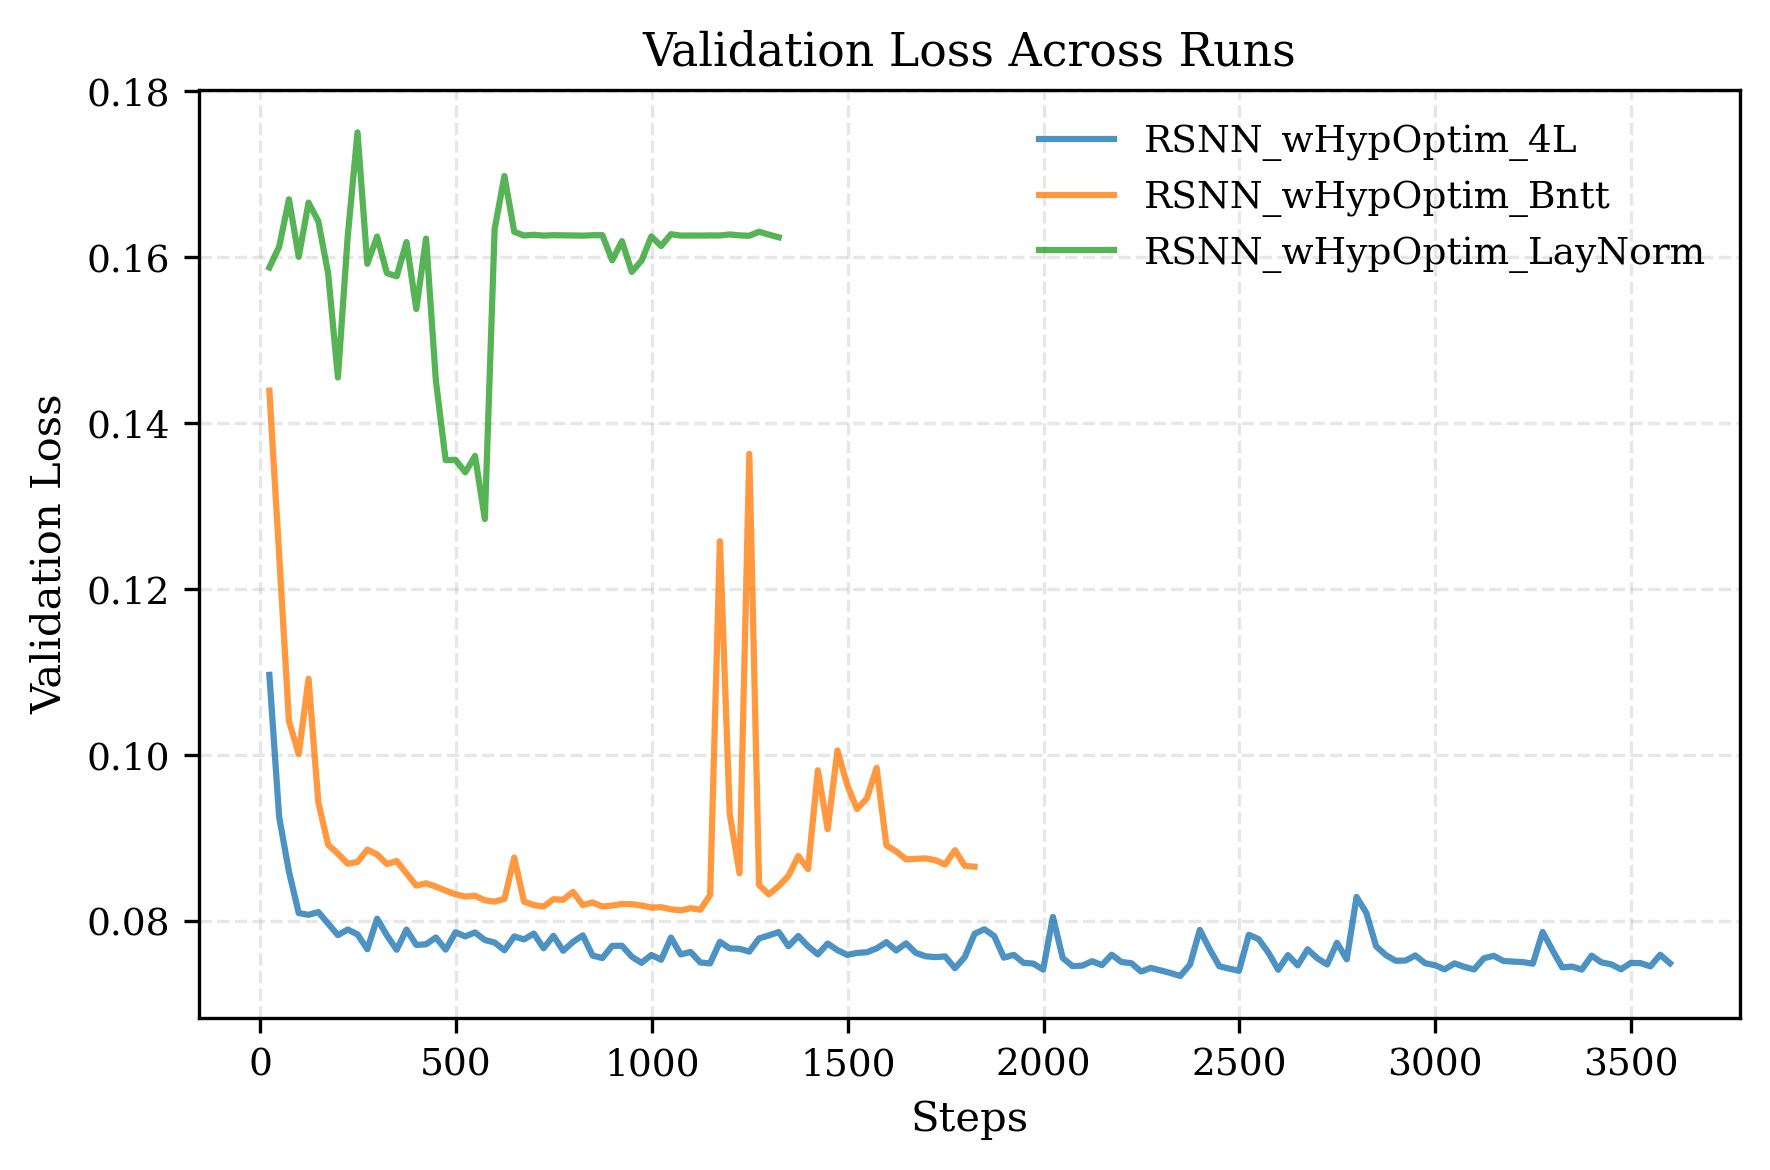

In [40]:
import matplotlib.pyplot as plt

include = ["GPT_Femto", "GPT_Nano", "RSNN_wHypOptim_4L"]
include = ["RSNN_wHypOptim_4L", "RSNN_wHypOptim_6L", "RSNN_wHypOptim_8L", "RSNN_wHypOptim_10L"]
include = ["RSNN_wHypOptim_4L", "RSNN_wHypOptim_Skip2", "RSNN_wHypOptim_Skip3", "RSNN_wHypOptim_Skip4"]
include = ["RSNN_wHypOptim_4L", "RSNN_wHypOptim_Bntt", "RSNN_wHypOptim_LayNorm"]


window = 1  # smoothing window, bigger smoother

fig, ax = plt.subplots(figsize=(6, 4))

for model_name in include:
    # select all runs with this model name, checks if multiple exist when trained with seed
    group = df[df["run_name"].str.startswith(model_name)].dropna(subset=["trainer/global_step", "val_loss"])
    
    if len(group) == 0:
        continue
    
    # Compute mean and std at each step
    stats = group.groupby("trainer/global_step")["val_loss"].agg(["mean", "std"])
    
    # Optional smoothing
    stats["mean"] = stats["mean"].rolling(window, min_periods=1).mean()
    
    # Plot mean line
    ax.plot(stats.index, stats["mean"], label=model_name, alpha=0.8)
    
    # Shaded ±1 std
    ax.fill_between(stats.index,
                    stats["mean"] - stats["std"],
                    stats["mean"] + stats["std"],
                    alpha=0.2)

# Labels, title, grid, legend
ax.set_xlabel("Steps")
ax.set_ylabel("Validation Loss")
ax.set_title("Validation Loss Across Runs")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(frameon=False)

plt.tight_layout()

# Save the figure
# fig.savefig("fully_trained_val_loss.png", bbox_inches="tight")
fig.savefig("comparsion_normalization.png", bbox_inches="tight")

plt.show()

### 2.3 Spiking Activity

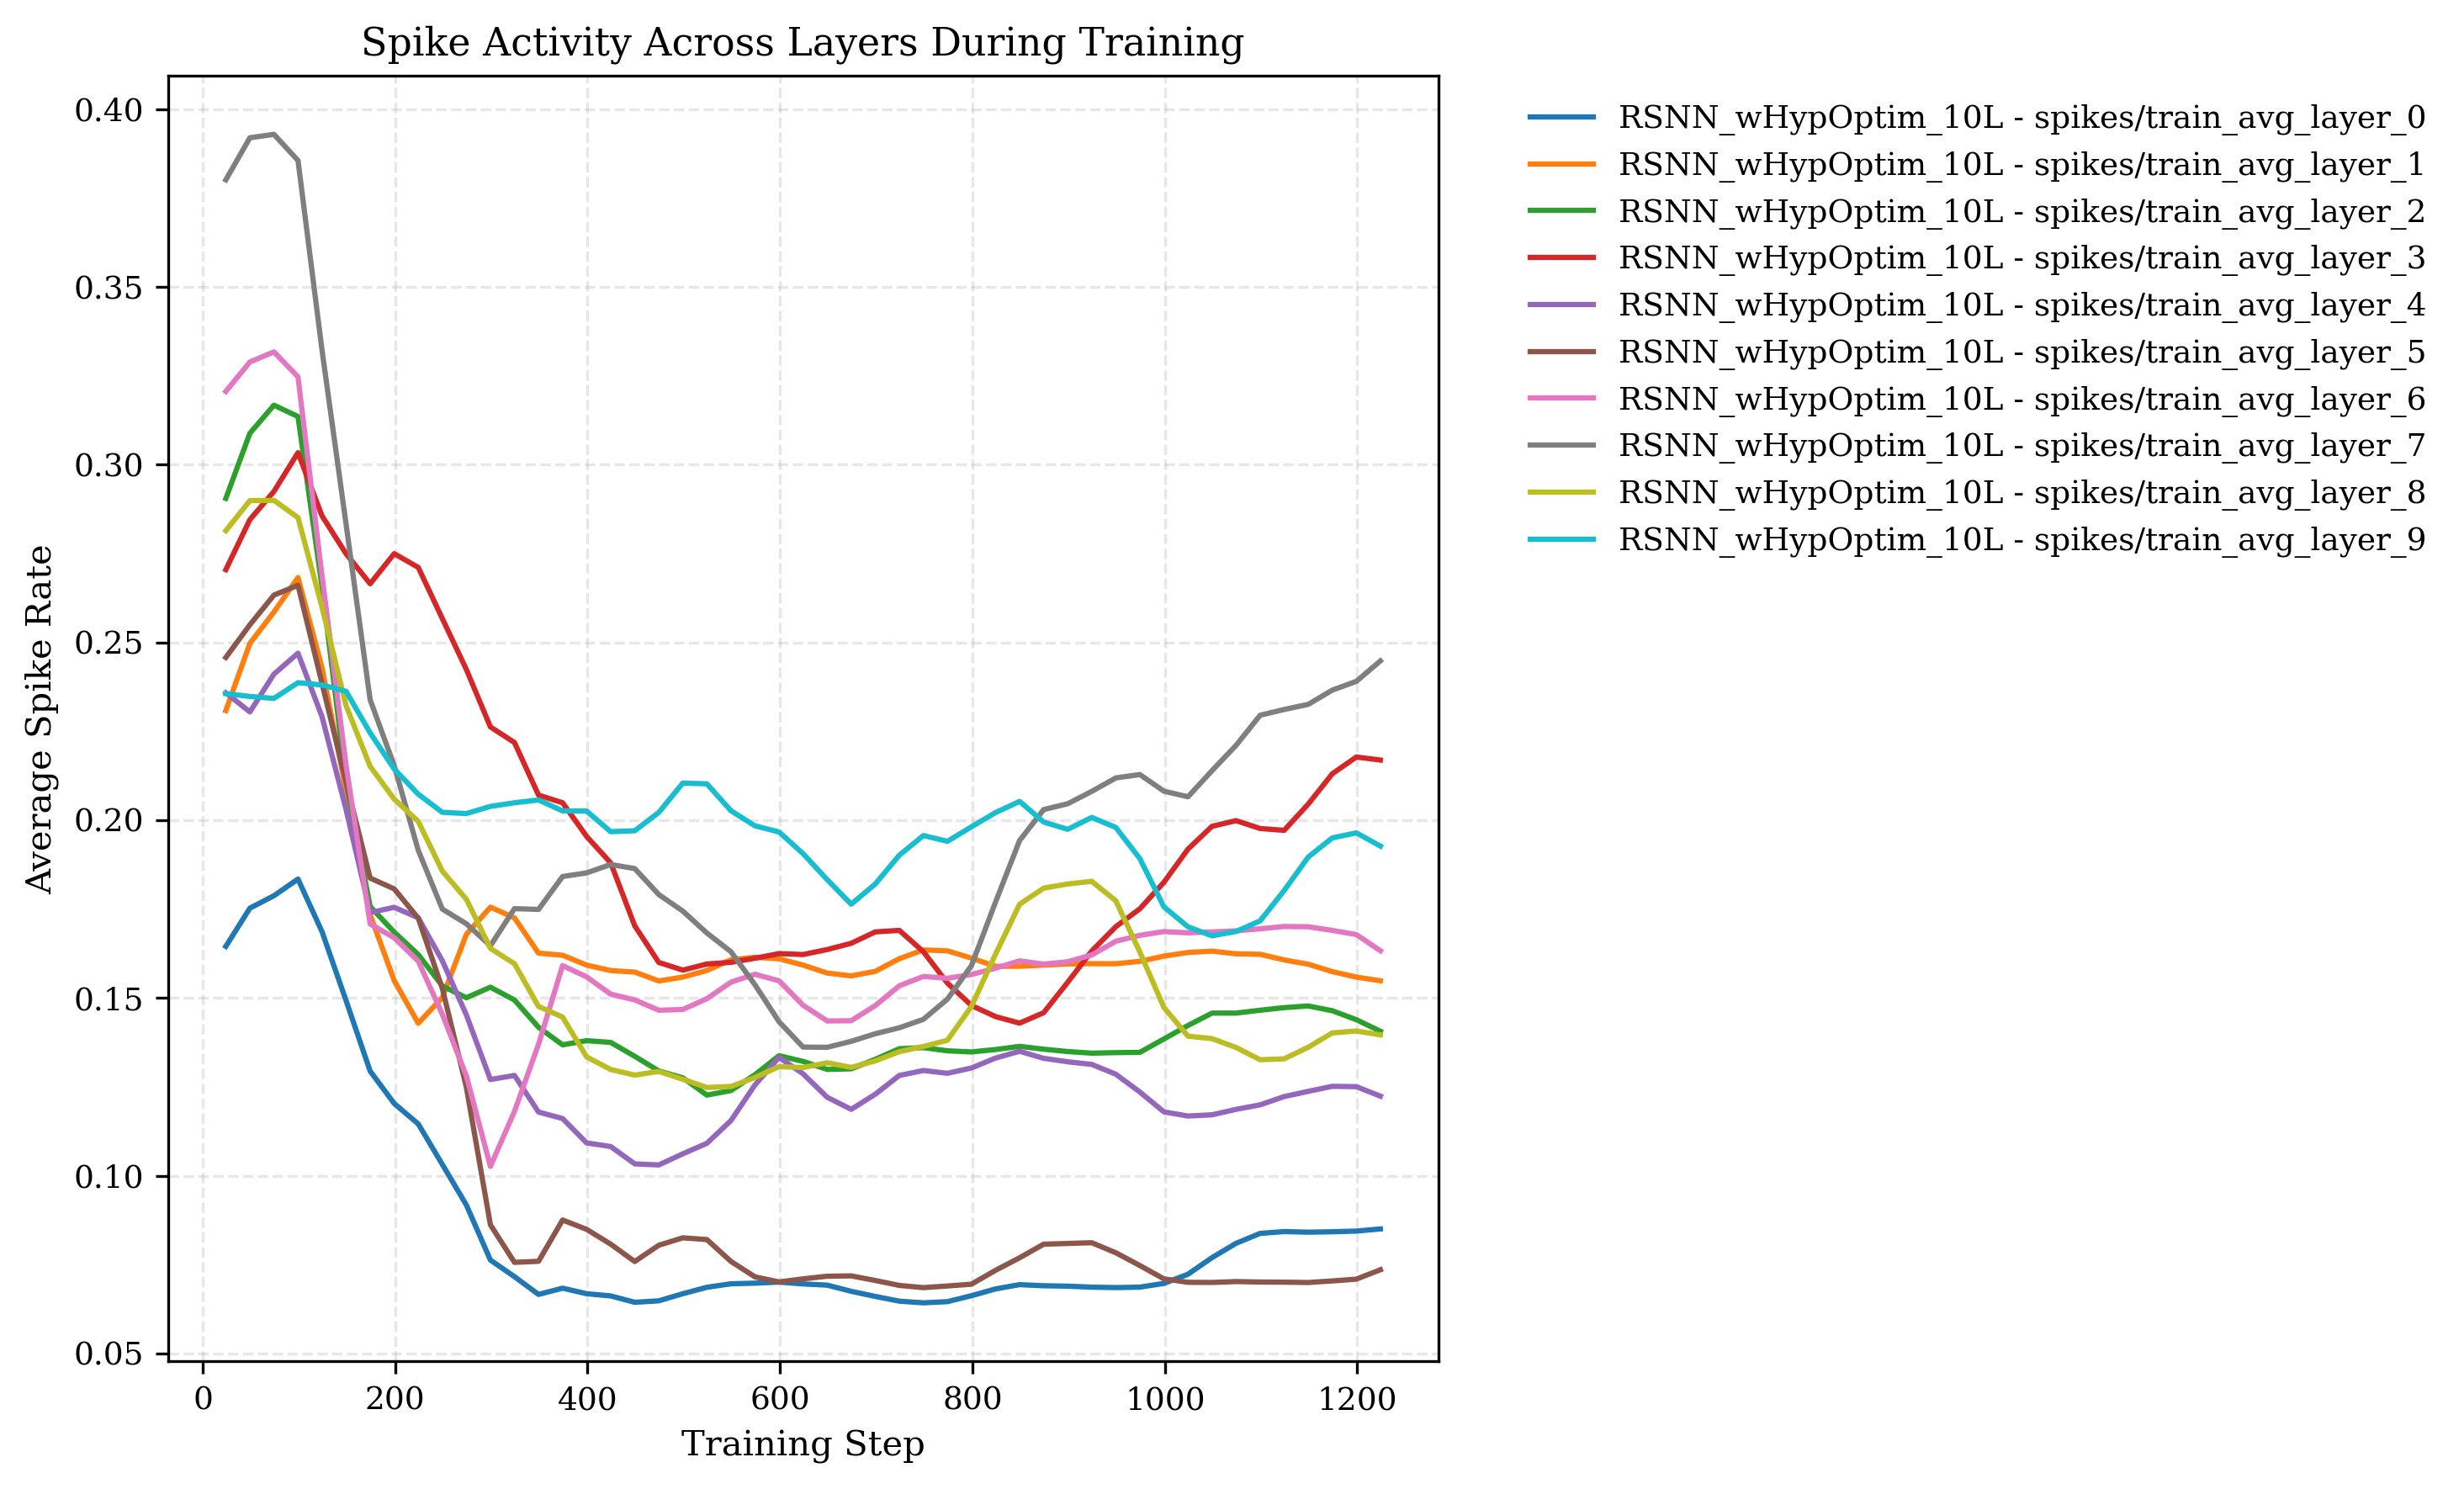

In [29]:
import matplotlib.pyplot as plt

spike_cols = sorted([c for c in df.columns if c.startswith("spikes/train_avg_layer")])
models = ["RSNN_wHypOptim_10L"]

plt.figure(figsize=(10, 6))

for model_name in models:
    group = df[df["run_name"] == model_name].dropna(subset=["trainer/global_step"] + spike_cols)
    if len(group) == 0:
        continue

    # Stack multiple runs if you have them (same run_name but different seeds)
    for col in spike_cols:
        # Compute mean and std across runs at each step
        stats = group.groupby("trainer/global_step")[col].agg(["mean", "std"])
        stats["mean"] = stats["mean"].rolling(window=3, min_periods=1).mean()
        
        plt.plot(stats.index, stats["mean"], label=f"{model_name} - {col}")
        plt.fill_between(stats.index, stats["mean"] - stats["std"], stats["mean"] + stats["std"], alpha=0.2)

plt.xlabel("Training Step")
plt.ylabel("Average Spike Rate")
plt.title("Spike Activity Across Layers During Training")
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("spike_activity_layers_mean_std.pdf", bbox_inches="tight")
plt.show()


### 2.4 Gradients

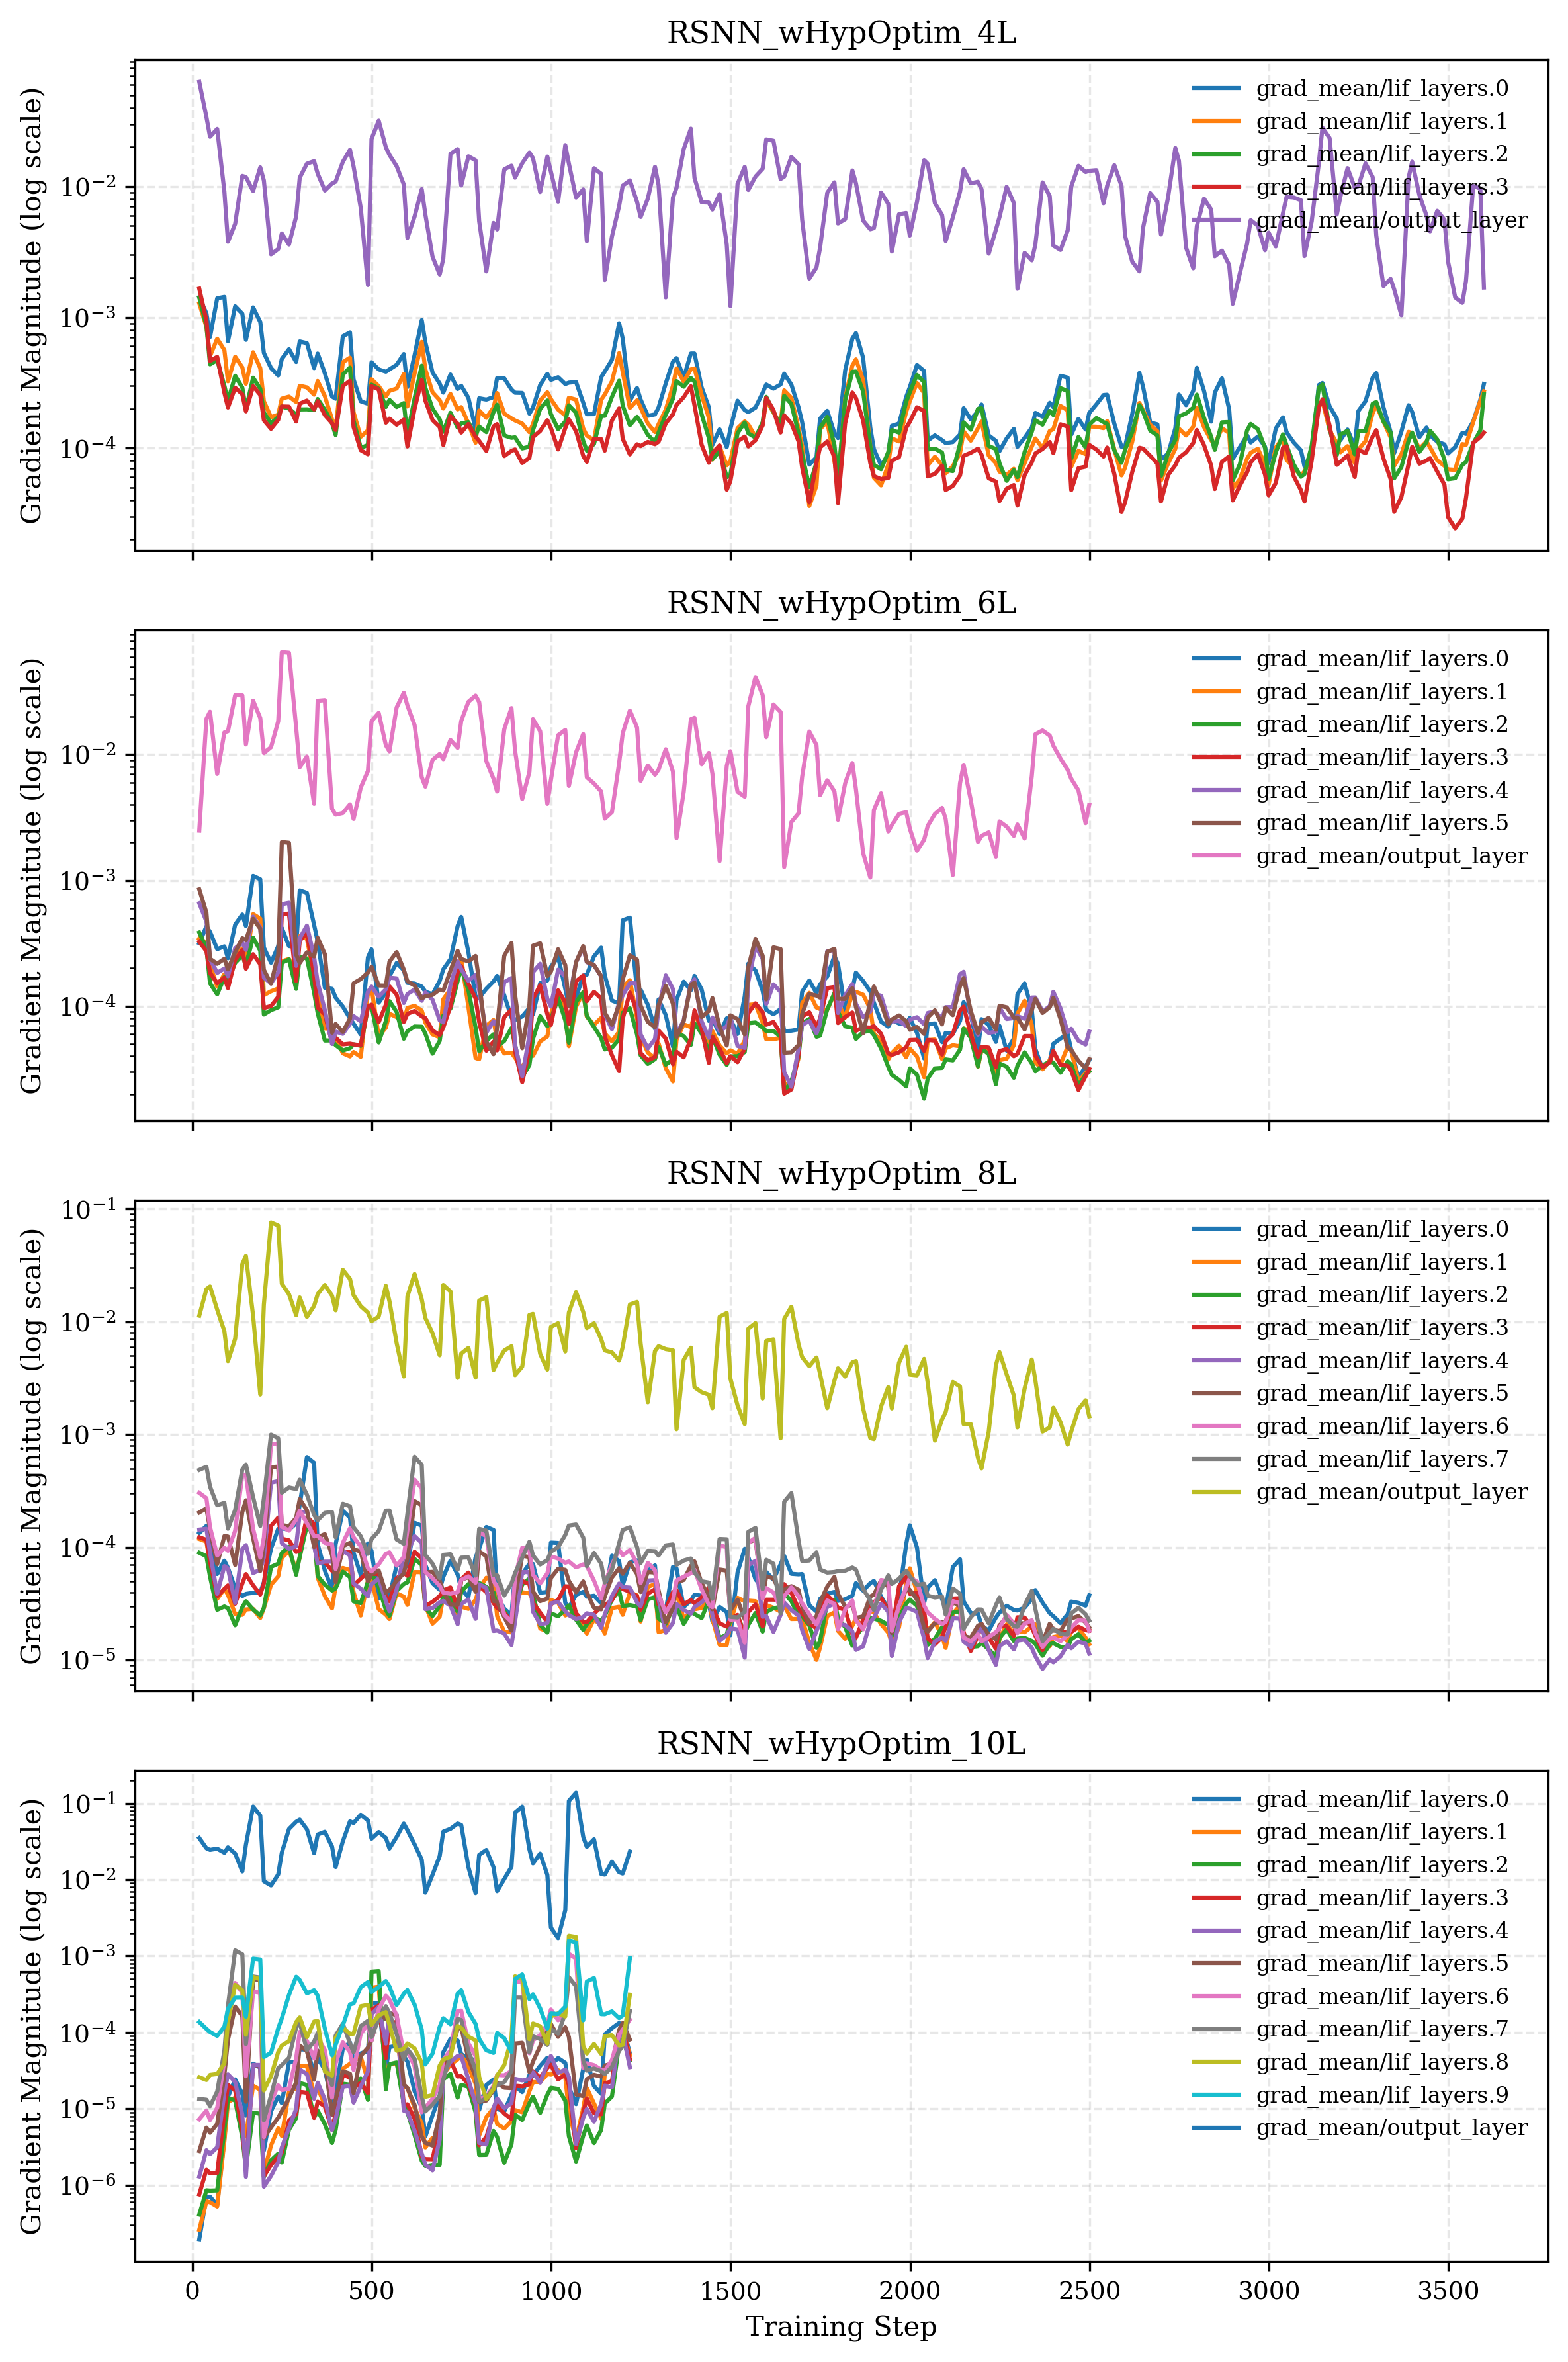

In [38]:
import matplotlib.pyplot as plt

grad_cols = sorted([c for c in df.columns if c.startswith("grad_mean/")])
include = ["RSNN_wHypOptim_4L", "RSNN_wHypOptim_6L", "RSNN_wHypOptim_8L", "RSNN_wHypOptim_10L"]
window = 2

fig, axes = plt.subplots(len(include), 1, figsize=(8, 3*len(include)), sharex=True)

if len(include) == 1:
    axes = [axes]  # ensure axes is iterable

for ax, model_name in zip(axes, include):
    group = df[df["run_name"] == model_name].dropna(subset=["trainer/global_step"])
    if len(group) == 0:
        continue
    
    for col in grad_cols:
        data = group[["trainer/global_step", col]].dropna()
        if len(data) == 0:
            continue
        
        # Smooth gradient
        smooth_grad = data[col].rolling(window=window, min_periods=1).mean()
        ax.plot(data["trainer/global_step"], smooth_grad, label=col)
    
    ax.set_yscale("log") 
    ax.set_title(model_name)
    ax.set_ylabel("Gradient Magnitude (log scale)")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(frameon=False, fontsize=8)

axes[-1].set_xlabel("Training Step")

plt.tight_layout()
plt.savefig("gradients_layers_models_log.pdf", bbox_inches="tight") 
plt.show()